# COGS 108 - Final Project

## Important

- ONE, and only one, member of your group should upload this notebook to TritonED. 
- Each member of the group will receive the same grade on this assignment. 
- Keep the file name the same: submit the file 'FinalProject.ipynb'.
- Only upload the .ipynb file to TED, do not upload any associted data. Make sure that for cells in which you want graders to see output that these cells have been executed.

## Group Members: Fill in the Student IDs of each group member here

Replace the lines below to list each persons full student ID, ucsd email and full name.

- A12170444, dylew@ucsd.edu, Daniel Lew
- A13107276, e3pineda@ucsd.edu, Elimelec Pineda 
- A12678538, jshi@ucsd.edu, Jamie Shi

## Introduction and Background

ELO is a system designed to calculate the relative skill level of players or teams in competitions, and is used to help predict the outcome of a match. These ratings constantly change as more games are played, and calculate a team's win percentage. 

*practicallypredictable*, a sports analytics site, provides additional information about this topic by analyzing different factors affecting ELO, such as ratings over time, strength of schedule, and team matchups. As a season progresses, rosters may change as a result of player injuries, which can affect a team's ELO depending on the level of impact that injured player had on the team. *practicallypredictable* also incorporates strength of schedule in ELO to demonstrate that teams with more wins in more difficult schedules throughout the season are more likely to have higher ELOs than teams with more wins in weaker schedules. In addition, team matchups can affect ELO due to upsets, in which the less favored team defeats the statistically stronger team. This unpredictable outcome heavily sways a team's rating to a greater value, which can lead to higher chances of winning more games.

In the context of the NBA, the average ELO hovers at around 1500. In one of its [articles](https://fivethirtyeight.com/features/how-we-calculate-nba-elo-ratings/?fbclid=IwAR08nfRrzwBOP5yNaxZe4qdc0C4kPl3Tb7v0XXLoVQ6B5f43ajgNJbzU6PU), FiveThirtyEight includes a table that highlights the approximate benchmarks for various ELO ratings:

<!-- 
Previous intro

    ELO statistics is a system designed to calculate the relative skill levels of players or teams in competition, and used as a predictor for an outcome of a match. These ratings are constantly changing as more games are played and calculate a team's winning percentage based on their winning record. We wanted to study if ELO ratings for an NBA team during one season can help predict their win percentage in following seasons. 

    According to practicallypredictable, they analyze different factors that affect an ELO stat, such as ratings over time, strength of schedule, and team matchups. As a season progresses, rosters may adjust due to a player becoming injured, which could affect a team's ELO statistic depending on the impact that injured player had on the team's winning percentage. They incorporated strenghth of schedule in ELO stats to demonstrate that teams with wins in more difficult schedules throughout the season are more likely to have higher ELO's than teams with weaker schedules. Finally, team matchups can also affect the ELO ratings due to an upset, which means a less favored team beating a stronger team based on stats. This unpredictable outcome heavily sways a team's rating to a higher number, which could lead to higher chances of winning more games.

    As discussed previously, it’s clear that higher ELO is correlated with getting more wins. Yet, depending on whether it is the regular season or playoffs, this condition may overestimate or underestimate a team’s probability of winning. For example, in the regular season, stronger teams such as the 2018 Golden State Warriors would “coast,” or play with less effort, and lose meaningless games they should have won. Going by Elo rating, 538 gives Golden State just a 14% chance of winning another championship in 2019. This model under-rates Golden State’s ability to win games that matter, as the team is known to pick up the pace in April and dominate the playoffs. -->

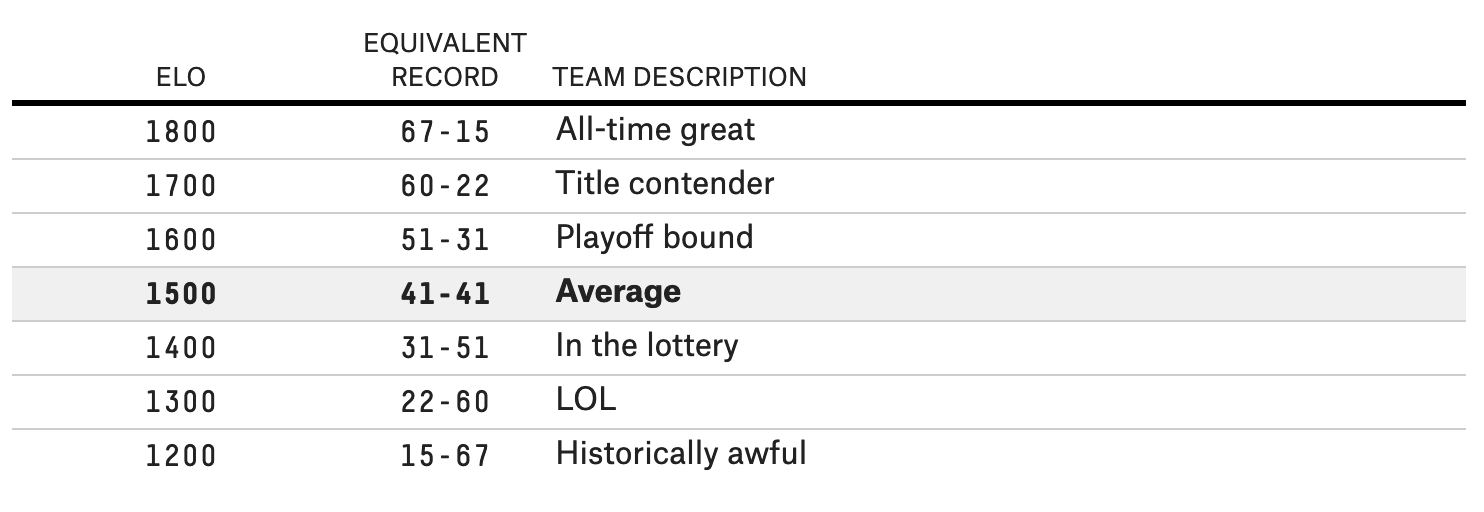

In [1]:
from IPython.display import Image
from IPython.display import Markdown as md
Image("img/eloTable.png")

The table above conveys the idea that teams whose ELO ratings differ by just 100 points can have noticeably different win records. Another detail to note is that 75% of a team's ELO carries over to the subsequent NBA season. As explained by FiveThirtyEight, if a team ends a season with an ELO of 1754, then it will start the next season with an ELO of (.75 \* 1754) + (.25 \* 1505) = 1692, with the 1505 representing the long-term ELO rating, slightly above the standard 1500 to account for expansion teams. 

ELO can be used to see whether certain NBA teams are more successful than others, over the span of their existence. It can also be used to help predict how likely a team is to win the next NBA championship. However, how significant does ELO for each team change from one year to the next? From one decade to the next? We will observe and analyze how ELO for NBA teams rise and decay over time. 

## Description of the Data

The data that will be used for analysis comes from Kaggle, hosted by FiveThirtyEight through their [GitHub](https://github.com/fivethirtyeight/data/tree/master/nba-elo). It contains 23 columns and 120,890 rows, and comprises NBA game statistics including but not limited to game results, game locations, years, team, and opponent ELO. This information enables us to more closely observe teams' ELO throughout their active years.

## Cleaning the Data

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#uncomment imports below if you need them
#import nltk
#from nltk.tokenize import word_tokenize
#from nltk.corpus import stopwords

#from sklearn.svm import SVC
#from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#from sklearn.metrics import classification_report, precision_recall_fscore_support

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

In [3]:
# Save the data
eloDf = pd.read_csv('nbaallelo.csv')

In [4]:
# Look at the data
eloDf.head(5)

,gameorder,game_id,lg_id,_iscopy,year_id,date_game,seasongame,is_playoffs,team_id,fran_id,...,win_equiv,opp_id,opp_fran,opp_pts,opp_elo_i,opp_elo_n,game_location,game_result,forecast,notes
0,1,194611010TRH,NBA,0,1947,11/1/1946,1,0,TRH,Huskies,...,40.294830,NYK,Knicks,68,1300.0000,1306.7233,H,L,0.640065,NaN
1,1,194611010TRH,NBA,1,1947,11/1/1946,1,0,NYK,Knicks,...,41.705170,TRH,Huskies,66,1300.0000,1293.2767,A,W,0.359935,NaN
2,2,194611020CHS,NBA,0,1947,11/2/1946,1,0,CHS,Stags,...,42.012257,NYK,Knicks,47,1306.7233,1297.0712,H,W,0.631101,NaN
3,2,194611020CHS,NBA,1,1947,11/2/1946,2,0,NYK,Knicks,...,40.692783,CHS,Stags,63,1300.0000,1309.6521,A,L,0.368899,NaN
4,3,194611020DTF,NBA,0,1947,11/2/1946,1,0,DTF,Falcons,...,38.864048,WSC,Capitols,50,1300.0000,1320.3811,H,L,0.640065,NaN


As seen in the first five rows, the data already contains standardized versions of important columns such as team name, opponent name, game season, game location, and game result. We will also check to see whether the data contains any missing values.

In [5]:
# Check for any missing data
eloDf.isnull().sum()

gameorder             0
game_id               0
lg_id                 0
_iscopy               0
year_id               0
date_game             0
seasongame            0
is_playoffs           0
team_id               0
fran_id               0
pts                   0
elo_i                 0
elo_n                 0
win_equiv             0
opp_id                0
opp_fran              0
opp_pts               0
opp_elo_i             0
opp_elo_n             0
game_location         0
game_result           0
forecast              0
notes            120890
dtype: int64

The only column with missing data was under notes; however, we do not plan to use this observation. Since the other columns contain no missing values, we conclude that the data is clean.

In [6]:
# Drop columns we don't need
eloDf.drop(['game_id','lg_id','date_game','seasongame','gameorder','is_playoffs','pts','opp_pts','fran_id','opp_fran','game_location','notes'], axis=1, inplace=True)

We removed several columns that we believe will not be revelant in our analysis, so as to make the data frame easier to read. Columns that are kept either have revelancy to our hypothesis, or can be used for benchmark comparisons.

## Analysis of the Data

In [7]:
# Only take teams that played in last 30 years
df = eloDf[eloDf['year_id'] > 1984]
df.head()

,_iscopy,year_id,team_id,elo_i,elo_n,win_equiv,opp_id,opp_elo_i,opp_elo_n,game_result,forecast
51630,1,1985,WSB,1455.0490,1442.1162,34.773190,CHI,1377.2302,1390.1630,L,0.468122
51631,0,1985,CHI,1377.2302,1390.1630,29.584490,WSB,1455.0490,1442.1162,W,0.531878
51632,1,1985,BOS,1643.8761,1653.2661,56.125080,DET,1574.7426,1565.3525,W,0.455696
51633,0,1985,DET,1574.7426,1565.3525,47.593834,BOS,1643.8761,1653.2661,L,0.544304
51634,0,1985,GSW,1453.0502,1443.4432,34.909248,PHO,1537.4418,1547.0487,L,0.522447


First, we created another dataframe that only looks at games played in the last thirty years. This will make yearly comparisons between teams easier and more consistent. Since the data only went as far as 2015, we only took games starting at 1985.

In [8]:
# Find team IDs
uniqueTeams = df.team_id.unique()
print(uniqueTeams)
print(uniqueTeams.size)

['WSB' 'CHI' 'BOS' 'DET' 'GSW' 'PHO' 'ATL' 'NJN' 'PHI' 'CLE' 'UTA' 'SEA'
 'HOU' 'DAL' 'DEN' 'IND' 'KCK' 'POR' 'MIL' 'NYK' 'SAS' 'LAL' 'LAC' 'SAC'
 'CHH' 'MIA' 'MIN' 'ORL' 'VAN' 'TOR' 'WAS' 'MEM' 'NOH' 'CHA' 'NOK' 'OKC'
 'BRK' 'NOP' 'CHO']
39


Next, we will look at the unique teams that existed in our data. This will give us a visualization of the teams, and provide us with markers for each team name.

In [9]:
# Drop teams that haven't played at least 30 NBA seasons
for team in uniqueTeams:
    yearsPlayed = df.loc[df['team_id'] == team].year_id.unique().size
    if yearsPlayed < 30:
        df = df.drop(df[df.team_id == team].index)

uniqueTeams = df.team_id.unique()
uniqueTeams.size

20

In [10]:
print(uniqueTeams)

['CHI' 'BOS' 'DET' 'GSW' 'PHO' 'ATL' 'PHI' 'CLE' 'UTA' 'HOU' 'DAL' 'DEN'
 'IND' 'POR' 'MIL' 'NYK' 'SAS' 'LAL' 'LAC' 'SAC']


To make sure that comparisons are fair, we further reduce teams to those that played at least thirty NBA seasons, to ensure that we don't analyze teams that have played too few games within our timeframe.

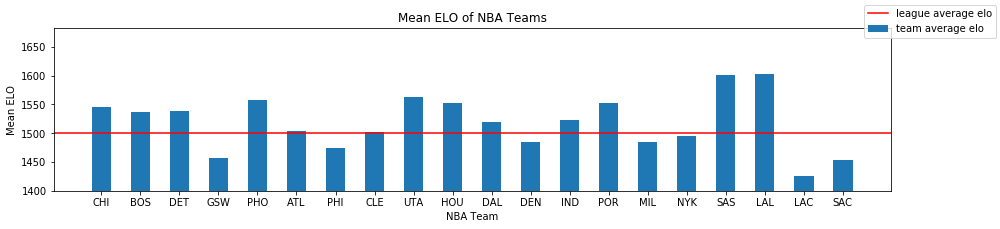

In [11]:
# Calculate the mean ELO of each NBA team over the past thirty years
meanTeamEloRatings = []
for team in uniqueTeams:
    meanTeamEloRatings.append(df.loc[df['team_id'] == team].elo_n.mean())

ax = plt.figure(figsize=(15, 3))
plt.bar(uniqueTeams, meanTeamEloRatings, width=0.5, label='team average elo')
plt.xlabel('NBA Team')
plt.ylabel('Mean ELO')
plt.title('Mean ELO of NBA Teams')
plt.axhline(y=1500, color='r', linestyle='-', label='league average elo')
ax.legend()

# Set ymin to 1400 to more clearly show differences in mean ELO between various teams
plt.ylim(bottom=1400) 
plt.show()

When we calculate the mean ELO of NBA teams over the past thirty years, we see that certain teams, most noticeably the Los Angeles Lakers (LAL) and San Antonio Spurs (SAS), stand out in terms of having higher mean ELO. Hence, compared to the rest of the league, the Lakers and Spurs as a whole have won a large percentage of their games, which contributes to them being viewed as some of the more successful NBA teams in the long run. Yet, the bar graph above does not accurately depict the strength of teams in the present. For instance, as of 2019, the Lakers will likely fail to make the playoffs. The Golden State Warriors (GSW), despite being one of the most dominant teams today, has historically been relatively weak, achieving a below average win percentage. 

Note that the bar graph above doesn't show the changes of ELO over time, but rather serves as an introduction to observing the ELO of various NBA teams. It provides us a glimpse of which teams have enjoyed more success in the long run. 

We will now proceed to analyzing ELO over time. We will address the first aspect of our question: Can an NBA team's ELO in one year reliably predict that team's ELO in subsequent years? 

First we will check whether there is a correlation for an NBA team's ELO from one year to the next. We will arbitrarily pick 2000 as our starting year, and see whether a team's ELO in 2000 has an effect on its ELO in 2001. 

In [12]:
def compareElo(teams, startYear, endYear): 
    ''' 
    Compares ELO of specified NBA teams from one year to another
    
    :param teams: An array of strings, each string representing a team name
                  i.e. ['GSW', 'LAL']
    :param startYear: An integer, representing the start year 
    :param endYear: An integer, representing the end year
    
    :returns An array of two elements
        The first element is an array of each team's mean ELO in the start year
        The second element is an array of each team's mean ELO in the end year
    '''

    elosBefore = []
    elosAfter = []

    for team in uniqueTeams:
        currTeamEloBefore = df.loc[df['team_id'] == team].loc[df['year_id'] == startYear].elo_n.mean()
        currTeamEloAfter = df.loc[df['team_id'] == team].loc[df['year_id'] == endYear].elo_n.mean()
        elosBefore.append(currTeamEloBefore)
        elosAfter.append(currTeamEloAfter)
    return [elosBefore, elosAfter]

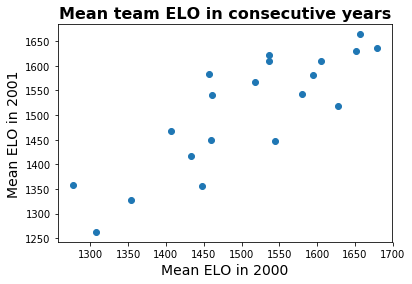

In [13]:
eloCompareResult = compareElo(uniqueTeams, 2000, 2001)
elosBefore = eloCompareResult[0]
elosAfter = eloCompareResult[1]
plt.scatter(elosBefore, elosAfter)
plt.title('Mean team ELO in consecutive years', fontsize=16, fontweight='bold')
plt.xlabel('Mean ELO in 2000', fontsize=14)
plt.ylabel('Mean ELO in 2001', fontsize=14)
plt.show()

From the scatter plot above, it appears that there is positive correlation between a team's mean ELO in 2000 and that same team's mean ELO in 2001. We can further verify this by using OLS regression:

In [14]:
eloComparisonsDf = pd.DataFrame({'elosBefore': elosBefore, 'elosAfter': elosAfter})

# Predict an NBA team's ELO in 2001 from its ELO in 2000
outcome, predictors = patsy.dmatrices('elosAfter ~ elosBefore', eloComparisonsDf)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              elosAfter   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     41.86
Date:                Wed, 20 Mar 2019   Prob (F-statistic):           4.37e-06
Time:                        18:20:01   Log-Likelihood:                -111.18
No. Observations:                  20   AIC:                             226.4
Df Residuals:                      18   BIC:                             228.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    232.4829    197.949      1.174      0.2

We see that the R-squared value is 0.699, which is fairly strong and suggests there is a positive correlation between a team's mean ELO in one year (2000) and its mean ELO in the immediate year afterwards (2001). In other words, if a team's ELO is high in the 2000 NBA season, its ELO will likely remain high in the 2001 NBA season. If a team's ELO is low in 2000, it will likely stay low in 2001. Logically this makes sense, because most teams will not undergo significant roster changes over the span of a single year, so the quality of their players and coaching staff won't be significantly different from one year to the immediate next.

Hence, there is indeed a relationship for a team's ELO in consecutive years. But what if we compare each team's ELOs after a longer period of time -- say ten years? We will now see whether a team's ELO in 2000 has an effect on its ELO in 2010. 

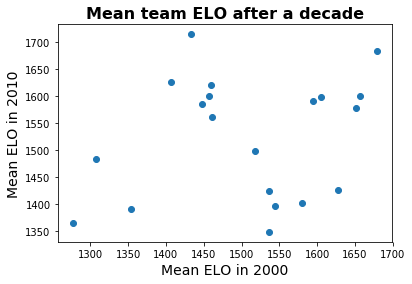

In [15]:
eloCompareResult = compareElo(uniqueTeams, 2000, 2010)
elosBefore = eloCompareResult[0]
elosAfter = eloCompareResult[1]
plt.scatter(elosBefore, elosAfter)
plt.title('Mean team ELO after a decade', fontsize=16, fontweight='bold')
plt.xlabel('Mean ELO in 2000', fontsize=14)
plt.ylabel('Mean ELO in 2010', fontsize=14)
plt.show()

From the scatter plot alone, it is apparent that a team's ELO after a decade is much less predictable. We now run OLS regression to view the quantitative data: 

In [16]:
eloComparisonsDf = pd.DataFrame({'elosBefore': elosBefore, 'elosAfter': elosAfter})

# Predict an NBA team's ELO in 2010 from its ELO in 2000
outcome, predictors = patsy.dmatrices('elosAfter ~ elosBefore', eloComparisonsDf)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              elosAfter   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.8804
Date:                Wed, 20 Mar 2019   Prob (F-statistic):              0.361
Time:                        18:20:02   Log-Likelihood:                -121.74
No. Observations:                  20   AIC:                             247.5
Df Residuals:                      18   BIC:                             249.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1211.2777    335.751      3.608      0.0

The R-squared value is 0.047, which is close to zero and indicates that there is close to no correlation in team ELO from one year to a decade later. Hence, it would be difficult to predict how well an NBA team would perform ten years from now. One can reason that this is because teams can drastically change over a span of ten years. Rosters could undergo a complete overhaul and overall talent level among players in a team could differ significantly. Such factors can contribute to a team's win percentage, and hence their ELO rating. 

In [17]:
def plotElo(teams, colors=None, conference=None):
    ''' 
    Creates a line plot displaying the ELO trends of the specified NBA teams
    
    :param teams: An array of strings, each string representing a team name
                  i.e. ['GSW', 'LAL']
    :param colors: An array of strings, each string representing the color
                   associated with a team
                   i.e. ['orange', 'purple']
    :param conference: A string, representing which conference the teams are in
                   i.e. 'Western' or 'Eastern'
    '''

    allTeamDataFrames = []
    # Extract ELO data from each team
    for team in teams:
        team = df.loc[df['team_id'] == team]
        activeYears = team.year_id.unique()
        eloData = []
        # Get mean ELO of each year for the current team
        for year in activeYears:
            meanEloThisYear = team.loc[df['year_id'] == year].elo_n.mean()
            eloData.append(meanEloThisYear)
        currDf = pd.DataFrame(eloData, columns=['meanElo'], index=activeYears)
        allTeamDataFrames.append(currDf)
    updatedDf = pd.concat(allTeamDataFrames, ignore_index=True, axis=1)
    updatedDf.columns = teams

    # Set color and names for axes
    stringifiedTeam = ', '.join(teams )
    if colors == None:
        ax = updatedDf.plot(kind='line', figsize=(12, 6)) 
        if conference != None:
            ax.set_title('ELO for ' + conference + ' teams over time', fontsize=16, fontweight='bold')
        else:
            ax.set_title('ELO for ' + stringifiedTeam + ' over time', fontsize=16, fontweight='bold')
        ax.set_xlabel('Year', fontsize=14)
        ax.set_ylabel('ELO', fontsize=14)
    else:
        ax = updatedDf.plot(kind='line', title='ELO for ' + stringifiedTeam + ' over time', color=colors)
        ax.set_title('ELO for ' + stringifiedTeam + ' over time', fontsize=16, fontweight='bold')
        ax.set_xlabel('Year', fontsize=14)
        ax.set_ylabel('ELO', fontsize=14)

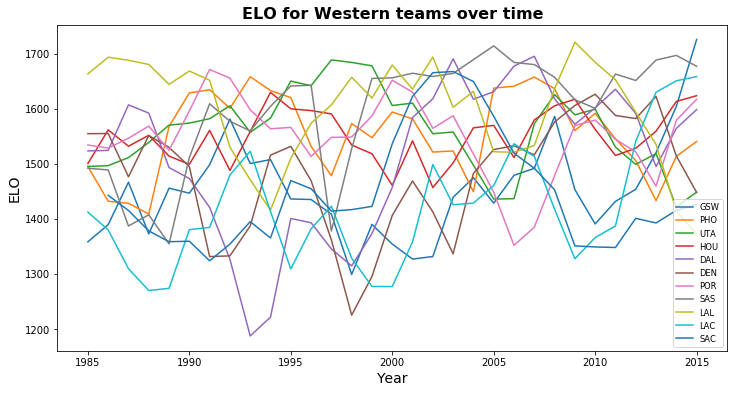

In [18]:
plotElo(['GSW', 'PHO', 'UTA', 'HOU', 'DAL', 'DEN', 'POR', 'SAS', 'LAL', 'LAC', 'SAC'],
       colors=None,
       conference='Western')
plt.legend(loc='lower right', fontsize='small')
plt.show()

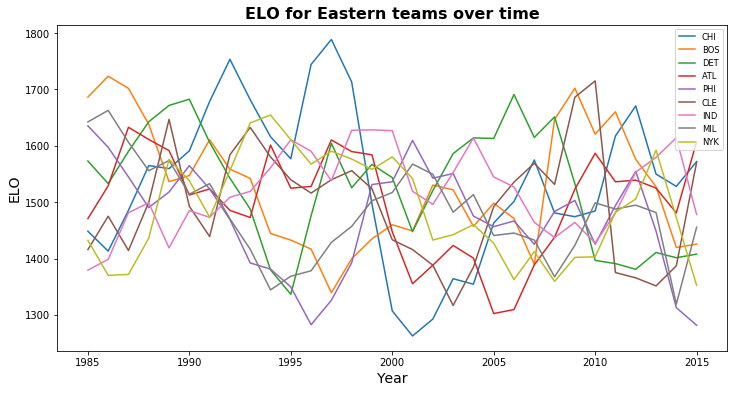

In [19]:
plotElo(['CHI', 'BOS', 'DET', 'ATL', 'PHI', 'CLE', 'IND', 'MIL', 'NYK'], 
        colors=None, 
        conference='Eastern')
plt.legend(fontsize='small')
plt.show()

From observing the graphs above, we can see that no NBA team's ELO stays constant over time; they all have rises and falls.

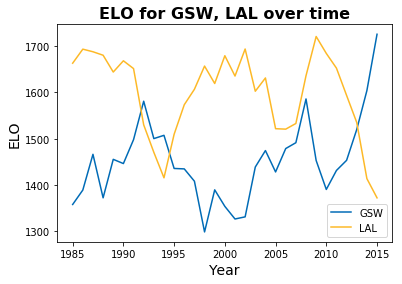

In [20]:
plotElo(['GSW', 'LAL'], ['#006BB6', '#FDB927'])

The two teams in our time frame include the Golden State Warriors (GSW) and Los Angeles Lakers (LAL). Comparing their average ELO through the last thirty years, we see that when one team has a high ELO rating, the other team (generally) has a low ELO rating. The highs for Golden State are also noticeably less high than those for the Lakers, suggesting that over the past few decades, the Lakers as a whole have enjoyed greater peaks of success than the warriors. However, it is also important to note that our data does not include games from more recent years (specifically 2016, 2017, and 2018), in which Golden State broke the regular season win record with a 73-9 season, and won two additional championships. The inclusion of this additional data would likely show that Golden State's peak ELO is higher than that of the Lakers, especially with Golden State currently having one of the most talented rosters of all time.

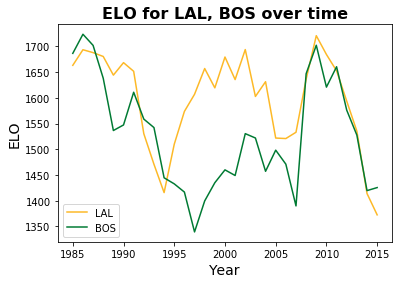

In [21]:
plotElo(['LAL', 'BOS'], ['#FDB927', '#007A33'])

We also compare the average ELO ratings of the Los Angeles Lakers (LAL) and Boston Celtics (BOS). These two teams are historical rivals, as they have met in the finals numerous times and have both dominated the NBA throughout different eras. Over the thirty year span, it appears that the Lakers have achieved more success than the Celtics. The ELO of these two teams have been comparable near the beginning and end of this timeframe (1985-2015), but the Celtics' win rate noticeably dipped from the mid 90's to mid 2000's, whereas the Lakers continued to dominate. 

Next, we will look at the highs and lows of ELO ratings over time. More specifically, we will find the teams along with their respective seasons associated with the highest and lowest ELOs over the last thirty years. 

In [22]:
import operator # Use to sort list of lists

highestElos = []
lowestElos = []

# Get the top ten lowest and highest ELOs, and store the result (along with their 
# corresponding team/year) in a list
for year in range(1986, 2016):
    for team in uniqueTeams:
        meanElo = df.loc[df['team_id'] == team].loc[df['year_id'] == year].elo_n.mean()
    
        currTeamData = [meanElo, team, year]
        numRows = 10
    
        # Find highest ELOs 
        if len(highestElos) < numRows:
            highestElos.append(currTeamData)
        else:
            highestEloMin = highestElos[numRows-1][0]
            if meanElo > highestEloMin:
                highestElos[numRows-1] = currTeamData
        highestElos.sort(key=operator.itemgetter(0), reverse=True) # Sort ELOs in descending order
            
        # Find lowest ELOs
        if len(lowestElos) < numRows:
            lowestElos.append(currTeamData)
        else:
            lowestEloMax = lowestElos[numRows-1][0]
            if meanElo < lowestEloMax:
                lowestElos[numRows-1] = currTeamData
        lowestElos.sort(key=operator.itemgetter(0)) # Sort ELOs in ascending order

highestElosDf = pd.DataFrame(highestElos, columns=['Mean ELO', 'Team', 'Year'])
lowestElosDf = pd.DataFrame(lowestElos, columns=['Mean ELO', 'Team', 'Year'])

In [23]:
highestElosDf.index.name = 'Highest ELOs in Past 30 Years'
highestElosDf

,Mean ELO,Team,Year
Highest ELOs in Past 30 Years,,,
0,1788.639541,CHI,1997
1,1753.427953,CHI,1992
2,1744.261468,CHI,1996
3,1725.574764,GSW,2015
4,1723.489248,BOS,1986
5,1720.708067,LAL,2009
6,1715.134781,CLE,2010
7,1713.914579,SAS,2005
8,1713.190981,CHI,1998


We see that the highest ELO ratings over the past thirty years are all above 1700. Referencing the benchmark of ELOs shown in our introduction section (i.e. [in the table created by FiveThirtyEight](https://fivethirtyeight.com/features/how-we-calculate-nba-elo-ratings/?fbclid=IwAR08nfRrzwBOP5yNaxZe4qdc0C4kPl3Tb7v0XXLoVQ6B5f43ajgNJbzU6PU)), all these teams are legitimate title contenders, with the top 3 or 4 achieving the status of all-time greats in the sport. 

In [24]:
lowestElosDf.index.name = 'Lowest ELOs in Past 30 Years'
lowestElosDf

,Mean ELO,Team,Year
Lowest ELOs in Past 30 Years,,,
0,1187.304340,DAL,1993
1,1221.580973,DAL,1994
2,1225.104035,DEN,1998
3,1262.646874,CHI,2001
4,1269.886312,LAC,1988
5,1273.777630,LAC,1989
6,1276.990429,LAC,2000
7,1277.208158,LAC,1999
8,1281.621929,PHI,2015


In contrast, teams with among the lowest ELOs over the past thirty years had ratings that were deemed "historically awful" by FiveThirtyEight (i.e. ELO < 1300). Although more analysis would be required to reach a solid conclusion, perhaps these teams have performed subpar as a result of having relatively weak rosters, or intentionally performed poorly in the hopes of receiving a higher draft pick. 

We will focus on the latter supposition. An often talked about but frowned upon idea in the NBA is for subpar teams to "tank," in which they intentionally lose games so as to increase their odds of receiving a high lottery pick. These higher picks increase the odds of a team getting a promising young prospect, who should in theory raise the team's win percentage by a considerable amount. However, it is also possible that these subpar teams have less competent front offices who are less capable of finding the right talent, and thereby end up using their first-round picks to draft players that don't succeed in the NBA. Despite this, we still presume that tanking teams will noticeably rise up in wins over the next several years, since the chances of drafting a serviceable player with a number 1 or 2 pick should be relatively high. 

In essence, we want to see whether teams with historically low ELOs are more likely to "bounce back" and improve their ELO in subsequent years at a significantly faster rate than that of the average NBA team. 

Later on, we also want to observe the trend of ELO changes among teams that achieved the highest mean ELO. From previous plots, we already know that ELO among NBA teams is not constant. But do these teams with historically high ELOs experience a sudden, rapid decline in their win percentage, or is the dropoff more gradual?

In [25]:
def getEloProgression(team, startYear, yearsToTrack):
    '''
    Get the mean ELO data for a team over a specified number of years, starting from a 
    specified starting year. This function will be used for plotting purposes
    
    :param teams: A string, representing a team name
                  i.e. 'GSW'
    :param startYear: An integer, representing the year to start tracking that team's ELO
                   associated with a team
    :param yearsToTrack: An integer, representing how many years (starting from startYear) 
                         to track ELO
                         
    :returns
        currTeamEloProgression: A list of integers, each integer representing the mean ELO
            for a particular year
        yearProgression: A list of consecutive integers, each integer a year in the specified
            time frame
    '''
    currTeamEloProgression = []
    yearProgression = [] 
    
    for year in range(startYear, startYear+yearsToTrack):
        currTeamMeanElo = df.loc[df['team_id'] == team].loc[df['year_id'] == year].elo_n.mean()
        currTeamEloProgression.append(currTeamMeanElo)
        yearProgression.append(year)
        
    return currTeamEloProgression, yearProgression

In [26]:
def getEloProgressionDf(recordElosDf, yearsToTrack):
    '''
    Get ELO progression of NBA teams over a specified time frame, and store the result in a
    dataframe. This function will be used more for quantitative analysis

    :param recordElosDf: A dataframe containing data about the highest or lowest mean ELOs
        for NBA teams over the past thirty years (i.e. lowestElosDf, highestElosDf)
    :param yearsToTrack: An integer, representing number of years to track ELO
    
    :returns A dataframe comprising ELO data over the past X years for NBA teams specified
        in recordElosDf
    '''
    
    numRows = recordElosDf.shape[0]
    meanElos = recordElosDf['Mean ELO']
    teams = recordElosDf['Team']
    startYears = recordElosDf['Year']
    allTeamMeanElos = []
    allTeamIds = []
    yearProgression = []
    for year in range(yearsToTrack):
        yearProgression.append('Year ' + str(year))

    # For each NBA team/year combination, get its current ELO and find its ELO in subsequent 
    # years. Append the result to a list 
    for rowIndex in range(numRows):
        currTeam = teams[rowIndex]
        currStartYear = startYears[rowIndex]
        currTeamId = currTeam + ' ' + str(currStartYear)
        allTeamIds.append(currTeamId)
        currTeamMeanElos = []
        for yearsFromStart in range(yearsToTrack):
            currYear = currStartYear + yearsFromStart
            currEloMean = df.loc[df['team_id'] == currTeam].loc[df['year_id'] == currYear].elo_n.mean()
            currTeamMeanElos.append(currEloMean)
        allTeamMeanElos.append(currTeamMeanElos)
    return pd.DataFrame(allTeamMeanElos, index=allTeamIds, columns=yearProgression)

In the table displaying the lowest mean ELOs, we see some of the same teams pop up within a one or two year time span. This may suggest that some bad teams stay bad for a relatively long period of time. For example, the Los Angeles Clippers (LAC) made the list for top 10 lowest ELO ratings in 1988, 1989 and 1999. Since the ELO trends over a ten-year time period would be interrelated for instances like this, we will only consider the earliest row (1988) and drop the others. In addition, there are some rows, such as Philadelphia 76ers (PHI), who made it to the top 10 worst ELO list in a relatively recent season -- 2015. Because we don't have any data past 2015, we cannot observe how the 76ers team's ELO changes post 2015, so we will drop rows like these as well. 

In [27]:
# If two teams in the data frame have the same name and are within a year of each other, 
# then we can drop one of the rows associated with that team because having just one of 
# the rows already accounts for that team's ELO changes over time, for a particular time span
def dropTeams(teamList, df):
    '''
    Given a dataframe of highest/lowest rated ELO seasons, drop all but one of the rows
    corresponding to the same teams in consecutive years. Also drop rows that include
    seasons past 2015, since there is insufficient data to observe later changes in ELO.

    :param teamList: A lists of lists, each list representing data (ELO/team/year) for
                     a particular year
                     i.e. [[1187.304340243902, 'DAL', 1993], [1221.5809731707318, 'DAL', 1994]
    :param df: A dataframe showing the ELO/team/year of the best or worsted rated year
    '''
    
    dfCopy = df
    for index, team in enumerate(teamList):
        currTeamName = team[1]
        currTeamYear = team[2]
        for prevIndex in range(index):
            prevTeam = teamList[prevIndex]
            prevTeamName = prevTeam[1]
            prevTeamYear = prevTeam[2]
            # Drop current team if team is already on the list and recorded that ELO 
            # within a year from current team
            if (currTeamName == prevTeamName) and (abs(currTeamYear - prevTeamYear) < 2):
                dfCopy = dfCopy.drop((dfCopy[
                    (dfCopy.Team == currTeamName) &
                    (dfCopy.Year == currTeamYear)].index))
            # Also drop teams on the top 10 list past 2015, because there isn't enough data 
            # to observe their changes in ELO over time
            dfCopy = dfCopy.drop((dfCopy[
                    (dfCopy.Team == currTeamName) &
                    (dfCopy.Year >= 2015)].index))        
    return dfCopy

In [28]:
# For the dataframe comprising the lowest ELOs over the past thirty years,
# drop rows that are repetitive or involve seasons that are too recent 
# (and hence lack sufficient data in following years)
lowestElosList = lowestElosDf.values.tolist()
lowestElosDfCopy = dropTeams(lowestElosList, lowestElosDf)
lowestElosDfCopy = lowestElosDfCopy.reset_index(drop=True) # Reset indices after dropping rows
lowestElosDfCopy

,Mean ELO,Team,Year
0,1187.304340,DAL,1993
1,1225.104035,DEN,1998
2,1262.646874,CHI,2001
3,1269.886312,LAC,1988
4,1276.990429,LAC,2000
5,1282.580640,PHI,1996


Now, let us see how the ELO of these lowest rated NBA teams (in a particular year) change over the next five years:

In [29]:
# For each of the lowest rated NBA teams, track their ELO over the next five years
# (Year 0 is ELO at the start, year 1 is ELO one year later, etc.)
lowestEloTrends = getEloProgressionDf(lowestElosDfCopy, 6).T
lowestEloTrends

,DAL 1993,DEN 1998,CHI 2001,LAC 1988,LAC 2000,PHI 1996
Year 0,1187.304340,1225.104035,1262.646874,1269.886312,1276.990429,1282.580640
Year 1,1221.580973,1295.301208,1292.642778,1273.777630,1358.104980,1326.056990
Year 2,1400.622473,1406.128699,1364.242891,1380.356750,1498.569861,1392.473040
Year 3,1392.827591,1468.687539,1354.472920,1384.349698,1425.522213,1531.240171
Year 4,1345.329567,1412.629799,1463.041730,1479.478729,1428.529117,1536.228391
Year 5,1314.571302,1336.392076,1501.319601,1522.712971,1460.331110,1609.695390


In [30]:
# See the percent change in ELO after each year for each of these lowest ranked teams
lowestEloTrends.pct_change()

,DAL 1993,DEN 1998,CHI 2001,LAC 1988,LAC 2000,PHI 1996
Year 0,NaN,NaN,NaN,NaN,NaN,NaN
Year 1,0.028869,0.057299,0.023756,0.003064,0.063520,0.033898
Year 2,0.146565,0.085561,0.055390,0.083672,0.103427,0.050085
Year 3,-0.005565,0.044490,-0.007161,0.002893,-0.048745,0.099655
Year 4,-0.034102,-0.038169,0.080156,0.068717,0.002109,0.003258
Year 5,-0.022863,-0.053969,0.026163,0.029223,0.022262,0.047823


After one year, these low ranked teams experience an ELO increase of between 2.375% and 6.352%. After two years, these teams experience a larger ELO jump than previous, all increasing from between 5.009% and 14.657%. By the third year, we begin seeing more variation in team ELO changes, with some decreasing and some increasing.

In [31]:
# For the dataframe comprising the highest ELOs over the past thirty years,
# drop rows that are repetitive or involve seasons that are too recent 
# (and hence lack sufficient data in following years)
highestElosList = highestElosDf.values.tolist()
highestElosDfCopy = dropTeams(highestElosList, highestElosDf)
highestElosDfCopy = highestElosDfCopy.reset_index(drop=True) # Reset indices after dropping rows
highestElosDfCopy

,Mean ELO,Team,Year
0,1788.639541,CHI,1997
1,1753.427953,CHI,1992
2,1723.489248,BOS,1986
3,1720.708067,LAL,2009
4,1715.134781,CLE,2010
5,1713.914579,SAS,2005
6,1702.122708,BOS,2009


Similarly, we will observe how the ELO of the highest rated NBA teams change over the next five years:

In [32]:
# For each of the highest rated NBA teams, track their ELO over the next five years
highestEloTrends = getEloProgressionDf(highestElosDfCopy, 6).T
highestEloTrends

,CHI 1997,CHI 1992,BOS 1986,LAL 2009,CLE 2010,SAS 2005,BOS 2009
Year 0,1788.639541,1753.427953,1723.489248,1720.708067,1715.134781,1713.914579,1702.122708
Year 1,1713.190981,1681.675528,1701.847296,1684.198952,1375.161270,1683.895640,1620.729128
Year 2,1496.791292,1616.152185,1637.971560,1652.444958,1365.733179,1679.972167,1660.339218
Year 3,1307.133348,1576.996724,1536.398606,1593.565124,1351.438756,1657.043649,1575.956173
Year 4,1262.646874,1744.261468,1547.215017,1535.159237,1387.190009,1616.216813,1527.482177
Year 5,1292.642778,1788.639541,1610.772931,1414.011072,1570.473239,1600.585516,1419.620207


In [33]:
# See the percent change in ELO after each year for each of these highest ranked teams
highestEloTrends.pct_change()

,CHI 1997,CHI 1992,BOS 1986,LAL 2009,CLE 2010,SAS 2005,BOS 2009
Year 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year 1,-0.042182,-0.040921,-0.012557,-0.021217,-0.198220,-0.017515,-0.047819
Year 2,-0.126314,-0.038963,-0.037533,-0.018854,-0.006856,-0.002330,0.024440
Year 3,-0.126710,-0.024228,-0.062011,-0.035632,-0.010466,-0.013648,-0.050823
Year 4,-0.034034,0.106065,0.007040,-0.036651,0.026454,-0.024638,-0.030758
Year 5,0.023756,0.025442,0.041079,-0.078916,0.132126,-0.009672,-0.070614


In comparison to the lowest ranked teams, the highest ranked teams all experience decreases in ELO among the first few upcoming years. There is more variability in the changes in ELO after each year, as we see ELOs decline by 1.256% to 19.822% in the first year. In the second year, one team's ELO actually increased by 2.444% (in comparison to its ELO in the year previous), but other teams had ELO once again decline by up to 12.631%.

Now we will plot the data to acheive better visualization: 

In [34]:
# ax = highestEloTrends.plot()
# ax.legend(highestEloTrends.index, fontsize='small')
# columnHeadersList = highestEloTrends.columns.tolist()
# ax.set_xticklabels(columnHeadersList)
# plt.show()

In [35]:
def plotEloProgression(df, yearsToTrack):
    '''
    Plots ELO progression of specified NBA teams over a specified number of years
    
    :param df: A dataframe, containing data about mean ELO/team/year
               i.e. lowestElosDf, highestElosDf
    :param yearsToTrack: An integer, representing number of years to track ELO
    '''
    teamIds = []

    plt.figure(figsize=(8, 4))
    for index, row in df.iterrows():
        currELO = row[0]
        currTeam = row[1]
        currYear = row[2]
        currTeamId = currTeam + ' ' + str(currYear)
        teamIds.append(currTeamId)
        eloProgression, yearProgression = getEloProgression(currTeam, currYear, yearsToTrack)
        plt.scatter(yearProgression, eloProgression)

    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Mean ELO', fontsize=14)
    # Set y-limits for the lowest and highest ELO progression plots to be the same, 
    # to make it easier to compare the ELO changes of teams after each year
    plt.ylim(1100, 1800)
    plt.legend(teamIds, fontsize='small')

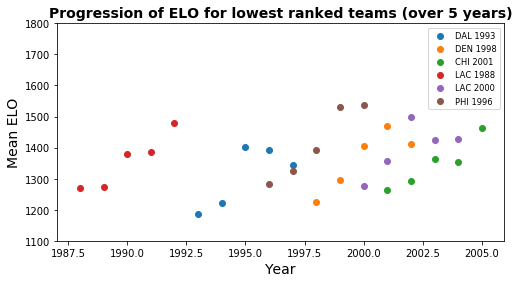

In [36]:
plotEloProgression(lowestElosDfCopy, 5)
plt.title('Progression of ELO for lowest ranked teams (over 5 years)', fontsize=14, fontweight='bold')
plt.show()

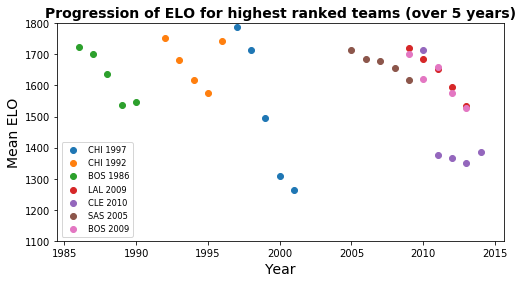

In [37]:
plotEloProgression(highestElosDfCopy, 5)
plt.title('Progression of ELO for highest ranked teams (over 5 years)', fontsize=14, fontweight='bold')
plt.show()

Naturally, teams with the historically lowest ELOs will rise in subsequent years; if they continued to dip then the lowest ELOs would actually be recorded in those later years. The same logic applies in reverse to teams with the historically highest ELOs.

What we are interested in investigating is *to what extent* ELO goes up for the lowest ranked teams, and *to what extent* ELO goes down for the highest ranked teams. 

As a whole, the points are more spaced out in the plot concerned with the lowest ranked teams. This can suggest that the lowest ranked teams generally increase in ELO at a higher rate than the highest ranked teams decline in ELO. However, in the plot displaying ELO progression for the highest ranked teams, some teams, such as the 2010 Cleveland Cavaliers and the 1997 Chicago Bulls, experienced sharp dips in ELO within the next two years. (On the other hand, we see no apparent spikes in the ELO progression plot for the lowest ranked teams.) 

Hence, we need more data to make a more solid conclusion on how ELO changes over time for the lowest/highest ranked NBA teams.  

To be continued...

## Results

(TBD)
(check if highest average ELO of year won)* <br>
(change avg ELO to last elo?)* <br>
(compare begining and midseason ELO) <br>
(compare ELos of previous and next year) <br>
(compare ELOs of previous 5 and next 5 years) <br>
(compare ELOs of previous 10 and next 10 years) <br>
(compare changes of ELOs) <br>
(spread the analysis to remaining 19 teams) <br>
look at ELOs of best/worst teams after 1 year/10 years <br>

## Privacy and Ethics

We have permission to use this dataset as the TAs have already approved of this usage as well as it being released to github and other open sources. This data does not violate any privacy matters as it only displays the numerical statistics of a team without revealing any personal information. Our data also includes all of the teams in the NBA, so there are not any potential biases regarding any exclusion of certain teams. 

## Conclusion

(TBD)